<a href="https://colab.research.google.com/github/cclmcesarschool/RNA-e-Deep-Learning---CESAR-School-2023.2/blob/main/Atividade3.1/3.1-LogisticRegressionIris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Carlos Cezar Lopes de Mendonça

In [1]:
%matplotlib inline
import os
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from IPython import display

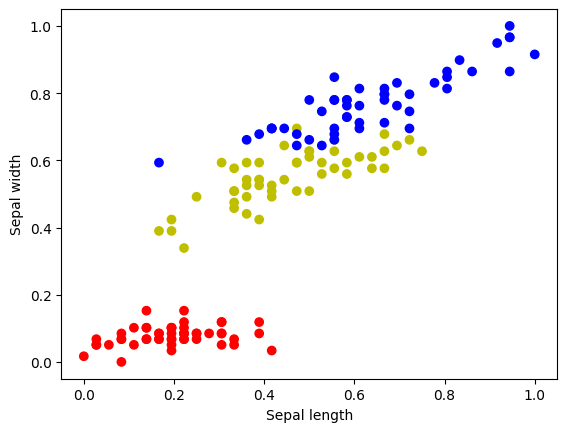

In [ ]:
iris = load_iris()
X = iris.data[:,::2]
Xc = X - X.min(axis=0)
Xs = Xc.max(axis=0)
Xc = Xc/Xs

Y = iris.target
colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

In [ ]:
X_tensor = torch.FloatTensor(Xc)
Y_tensor = torch.LongTensor(Y)

In [ ]:
Y_tensor

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

In [ ]:
model = nn.Linear(2,3)

In [ ]:
model.state_dict()

OrderedDict([('weight',
              tensor([[-0.3618, -0.3534],
                      [-0.1790, -0.6083],
                      [ 0.6565, -0.6142]])),
             ('bias', tensor([0.4522, 0.3652, 0.1727]))])

In [ ]:
out= model(Variable(X_tensor[:4,:]))
out

tensor([[0.3479, 0.2841, 0.2769],
        [0.3680, 0.2941, 0.2404],
        [0.3941, 0.3143, 0.2144],
        [0.3921, 0.2987, 0.1753]], grad_fn=<AddmmBackward0>)

In [ ]:
oo = F.softmax(out,dim=1)
oo

tensor([[0.3485, 0.3269, 0.3246],
        [0.3560, 0.3306, 0.3134],
        [0.3625, 0.3347, 0.3028],
        [0.3682, 0.3354, 0.2964]], grad_fn=<SoftmaxBackward0>)

In [ ]:
F.softmax(out,dim=1)*100

tensor([[34.8459, 32.6950, 32.4591],
        [35.5991, 33.0641, 31.3368],
        [36.2460, 33.4690, 30.2850],
        [36.8203, 33.5361, 29.6436]], grad_fn=<MulBackward0>)

In [ ]:
prob,y_pred = torch.max(F.softmax(out,dim=1),dim=1)
print(y_pred)
print(prob)

tensor([0, 0, 0, 0])
tensor([0.3485, 0.3560, 0.3625, 0.3682], grad_fn=<MaxBackward0>)


In [ ]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)
    return predicts.data.numpy()

In [ ]:
def predict_prob(model, inputs):
    outputs = model(Variable(inputs))
    outputs = F.softmax(outputs, dim=1)
    prob, predicts = torch.max(outputs, 1)
    return prob.data.numpy(), predicts.data.numpy()

In [ ]:
class MyPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h=.01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        # Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(12, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 3, 1)
        self.ax1.set_xlim(0, n_epoch)
        self.ax1.set_xlabel('Epoca')
        self.ax1.set_ylabel('Perda')
        self.ax1.set_title('Perda x Época')
        self.ax1.plot([], [], 'b', linewidth=2.0, label="Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 3, 2)
        self.ax2.set_xlim(Xc[:, 0].min(), Xc[:, 0].max())
        self.ax2.set_ylim(Xc[:, 1].min(), Xc[:, 1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')
        self.ax2.set_ylabel('Largura da Sepala')
        self.ax2.set_title('Fronteiras de decisão')

        self.ax3 = self.fig.add_subplot(1, 3, 3)
        self.ax3.set_xlim(Xc[:, 0].min(), Xc[:, 0].max())
        self.ax3.set_ylim(Xc[:, 1].min(), Xc[:, 1].max())
        self.ax3.set_xlabel('Comprimento da Sepala')
        self.ax3.set_ylabel('Largura da Sepala')
        self.ax3.set_title('Máxima probabilidade')

In [ ]:
def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

In [ ]:
def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch % 250 == 0:
                self.ax1.plot(np.arange(epoch + 1), self.loss_hist, 'b', linewidth=2.0)

                Zc = predict(self.model, torch.FloatTensor(self.X_grid))
                Zc = Zc.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Zc, cmap=plt.cm.Paired)
                colors = np.array(['r', 'y', 'b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                Zp = predict_prob(self.model, torch.FloatTensor(self.X_grid))[1]
                Zp = Zp.reshape(self.xx.shape)

                self.ax3.pcolormesh(self.xx, self.yy, Zp, cmap=plt.cm.magma)
                colors = np.array(['r', 'y', 'b'])
                self.ax3.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

In [ ]:
def initialize_weights(model):
    if isinstance(model, nn.Linear):
        nn.init.kaiming_uniform_(model.weight)
        if model.bias is not None:
            nn.init.constant_(model.bias, 0)

AttributeError: 'MyPlotter' object has no attribute 'on_epoch_end'

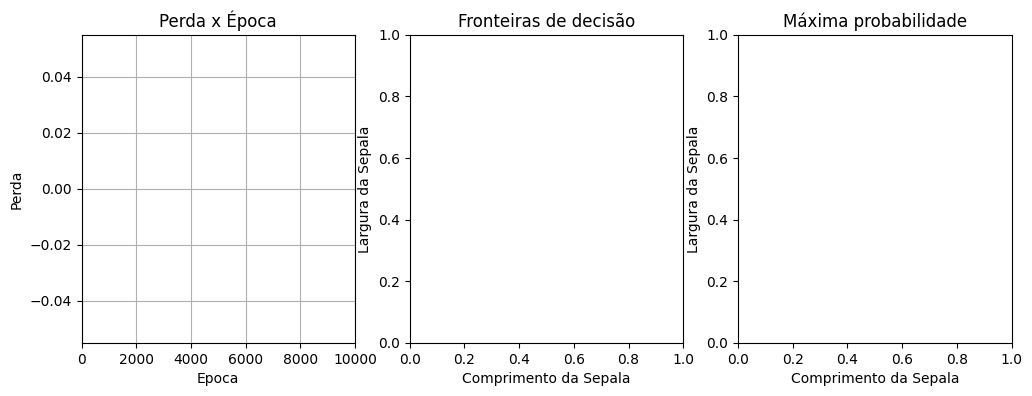

In [ ]:
lr = 0.15
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

nb_epoch = 10000

myplot = MyPlotter(model, Xc, Y, nb_epoch)

# Reinicializar os pesos do modelo
model.apply(initialize_weights)

# Treinamento do modelo
losses = []
for i in range(nb_epoch):
    output = model(Variable(X_tensor))
    loss = criterion(output, Variable(Y_tensor))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data.item())
    myplot.on_epoch_end(i, {'loss': loss.data.item()})
    final_loss = loss.data.item()

print('Final loss:', final_loss)

In [ ]:
# Verificar a amostra classificada corretamente com maior probabilidade
probs, preds = predict_prob(model, X_tensor)
correct = preds == Y
correct_probs = probs[correct]

if len(correct_probs) > 0:
    max_prob_index = np.argmax(correct_probs)
    max_prob = correct_probs[max_prob_index]
    sample_index = np.where(correct)[0][max_prob_index]

    print(f'Amostra classificada corretamente com maior probabilidade:')
    print(f'Índice: {sample_index}')
    print(f'Probabilidade: {max_prob:.4f}')
    print(f'Características: {X[sample_index]}')
    print(f'Rótulo verdadeiro: {Y[sample_index]}')
else:
    print('Nenhuma amostra foi classificada corretamente.')

Amostra classificada corretamente com maior probabilidade:
Índice: 118
Probabilidade: 0.8990
Características: [7.7 6.9]
Rótulo verdadeiro: 2


In [ ]:
# Verificar a amostra classificada erroneamente com maior probabilidade
probs, preds = predict_prob(model, X_tensor)
incorrect = preds != Y
incorrect_probs = probs[incorrect]

if len(incorrect_probs) > 0:
    max_prob_index = np.argmax(incorrect_probs)
    max_prob = incorrect_probs[max_prob_index]
    sample_index = np.where(incorrect)[0][max_prob_index]

    print(f'Amostra classificada erroneamente com maior probabilidade:')
    print(f'Índice: {sample_index}')
    print(f'Probabilidade: {max_prob:.4f}')
    print(f'Características: {X[sample_index]}')
    print(f'Rótulo verdadeiro: {Y[sample_index]}')
else:
    print('Nenhuma amostra foi classificada erroneamente.')

Amostra classificada erroneamente com maior probabilidade:
Índice: 77
Probabilidade: 0.7846
Características: [6.7 5. ]
Rótulo verdadeiro: 1


In [ ]:
# Verificar a amostra classificada corretamente com menor probabilidade
probs, preds = predict_prob(model, X_tensor)
correct = preds == Y
correct_probs = probs[correct]

if len(correct_probs) > 0:
    min_prob_index = np.argmin(correct_probs)
    min_prob = correct_probs[min_prob_index]
    sample_index = np.where(correct)[0][min_prob_index]

    print(f'Amostra classificada corretamente com menor probabilidade:')
    print(f'Índice: {sample_index}')
    print(f'Probabilidade: {min_prob:.4f}')
    print(f'Características: {X[sample_index]}')
    print(f'Rótulo verdadeiro: {Y[sample_index]}')
else:
    print('Nenhuma amostra foi classificada corretamente.')

Amostra classificada corretamente com menor probabilidade:
Índice: 13
Probabilidade: 0.3373
Características: [4.3 1.1]
Rótulo verdadeiro: 0


In [ ]:
# Verificar a amostra classificada erroneamente com menor probabilidade
probs, preds = predict_prob(model, X_tensor)
incorrect = preds != Y
incorrect_probs = probs[incorrect]

if len(incorrect_probs) > 0:
    min_prob_index = np.argmin(incorrect_probs)
    min_prob = incorrect_probs[min_prob_index]
    sample_index = np.where(incorrect)[0][min_prob_index]

    print(f'Amostra classificada erroneamente com menor probabilidade:')
    print(f'Índice: {sample_index}')
    print(f'Probabilidade: {min_prob:.4f}')
    print(f'Características: {X[sample_index]}')
    print(f'Rótulo verdadeiro: {Y[sample_index]}')
else:
    print('Nenhuma amostra foi classificada erroneamente.')

Amostra classificada erroneamente com menor probabilidade:
Índice: 22
Probabilidade: 0.3485
Características: [4.6 1. ]
Rótulo verdadeiro: 0


In [ ]:
model.state_dict()

OrderedDict([('weight',
              tensor([[-0.4094, -0.4352],
                      [-0.1625, -0.5775],
                      [ 0.6876, -0.5632]])),
             ('bias', tensor([0.4513, 0.3829, 0.1558]))])

In [ ]:
os.makedirs('../models',exist_ok=True)
torch.save(model.state_dict(),'../models/RegrLog_Iris.pt')

In [ ]:
! ls ../models/

RegrLog_Iris.pt


In [ ]:
nn.init.constant(model.weight,0)
model.state_dict()

<ipython-input-136-0d5512203613>:1: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(model.weight,0)


OrderedDict([('weight',
              tensor([[0., 0.],
                      [0., 0.],
                      [0., 0.]])),
             ('bias', tensor([0.4513, 0.3829, 0.1558]))])

In [ ]:
param_saved = torch.load('../models/RegrLog_Iris.pt')
model.load_state_dict(param_saved)
model.state_dict()

OrderedDict([('weight',
              tensor([[-0.4094, -0.4352],
                      [-0.1625, -0.5775],
                      [ 0.6876, -0.5632]])),
             ('bias', tensor([0.4513, 0.3829, 0.1558]))])

In [ ]:
Y_pred = predict(model, X_tensor)
accuracy = (Y_pred == Y).mean()
print('Training Accuracy: ', accuracy)

Training Accuracy:  0.5933333333333334


In [ ]:
import pandas as pd
pd.crosstab(Y_pred, Y)

col_0,0,1,2
row_0,,,
0,40,7,1
2,10,43,49


Observe que se após o treinamento, a célula for executada novamente, ela continua utilizando os parâmetros treinados até sua última execução. O que é preciso fazer para que o treinamento comece deste o início, como da primeira vez que foi executado?
É necessário reinicializar os parametros do modelo antes de iniciar o treinamento. Isso é feito com a função de inicialização de pesos padrão Pytorch.

Experimente refazer o treinamento com diferentes valores de learning rate

Refeito com 0,10 e 025

1. Observando o gráfico de máxima probabilidade, responda:
    1.** Qual é a amostra classificada corretamente, com maior probabilidade? Amostra classificada corretamente com maior probabilidade:**
Índice: 118
Probabilidade: 0.8990
Características: [7.7 6.9]
Rótulo verdadeiro: 2
    2. **Qual é a amostra classificada erradamente, com maior probabilidade? Amostra classificada erroneamente com maior probabilidade:**
Índice: 77
Probabilidade: 0.7846
Características: [6.7 5. ]
Rótulo verdadeiro: 1
    3. **Qual é a amostra classificada corretamente, com menor probabilidade? Amostra classificada corretamente com menor probabilidade:**
Índice: 13
Probabilidade: 0.3373
Características: [4.3 1.1]
Rótulo verdadeiro: 0
    4. **Qual é a amostra classificada erradamente, com menor probabilidade? Amostra classificada erroneamente com menor probabilidade:**
Índice: 22
Probabilidade: 0.3485
Características: [4.6 1. ]
Rótulo verdadeiro: 0

2. **Quantos parâmetros possui esta rede? Quantos são da camada densa e quantos são de bias?**  (2 * 3) + 3 = 6 + 3 = 9
2 unidades de entradas vezes 3 unidades de saida mais 3 unidades de saida = 9 parametros. 6 são pesos (parâmetros da camada densa) e 3 são viés (parâmetros de bias)

**3. Quantas entradas e quantas saídas esta rede possui?**
A rede possui 2 entradas e 3 saídas

**4. Como se pode calcular a acurácia a partir da matriz de confusão?**

A acurácia pode ser calculada a partir da matriz de confusão utilizando a seguinte fórmula:

Acuracia = Numero de previsões corretas/Número total de previsões

A matriz de confusão fornece o número de previsões corretas e incorretas para cada classe. A partir dela, podemos calcular o número total de previsões corretas somando os valores na diagonal principal (verdadeiros positivos) e dividindo pelo número total de previsões.


**5. O que faz a função `torch.max`? Quantos parâmetros ela retorna e quais seus significados?**


A função torch.max é usada para encontrar o valor máximo ao longo de uma dimensão específica de um tensor PyTorch.

Ela retorna dois tensores:

O primeiro tensor contém os valores máximos ao longo da dimensão especificada.
O segundo tensor contém os índices onde os valores máximos foram encontrados ao longo da dimensão especificada.